In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
#load data
ball_df = pd.read_csv('../data/results/ball_positions_interpolated.csv')
gk_df = pd.read_csv('../data/raw/gk_positions.csv')

ball_df = ball_df.rename(columns={"X": "ball_x", "Y": "ball_y"})
gk_df.columns = gk_df.columns.str.strip()  # Remove leading/trailing spaces
gk_df = gk_df.rename(columns={"X": "gk_x", "Y": "gk_y"})

#merge by frame
df = pd.merge(ball_df, gk_df, on="Frame", how="inner").sort_values("Frame")

#mark missing gk values
df["gk_missing"] = df[["gk_x", "gk_y"]].isnull().any(axis=1)

#Normalize
ball_min = df[["ball_x", "ball_y"]].min()
ball_max = df[["ball_x", "ball_y"]].max()
df[["ball_x", "ball_y"]] = (df[["ball_x", "ball_y"]] - ball_min) / (ball_max - ball_min)

gk_min = df[["gk_x", "gk_y"]].min()
gk_max = df[["gk_x", "gk_y"]].max()
df[["gk_x", "gk_y"]] = (df[["gk_x", "gk_y"]] - gk_min) / (gk_max - gk_min)

In [4]:
#create sequences for training
SEQ_LEN = 15
X_train, y_train = [], []

for i in range(SEQ_LEN, len(df)):
    if not df["gk_missing"].iloc[i]:  # only use frames where GK position is known
        ball_seq = df[["ball_x", "ball_y"]].iloc[i-SEQ_LEN:i].values
        gk_target = df[["gk_x", "gk_y"]].iloc[i].values
        X_train.append(ball_seq)
        y_train.append(gk_target)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

C:\Users\pedro\AppData\Local\Temp\ipykernel_15752\2605163169.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  X_train = torch.tensor(X_train, dtype=torch.float32)


LSTM

In [5]:
#define lstm model
class BallToGK_LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, output_size=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])  # last layer's hidden state

model = BallToGK_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [6]:
#train model
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

EPOCHS = 100
for epoch in range(EPOCHS):
    total_loss = 0
    for xb, yb in dataloader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss:.4f}")

Epoch 0: Loss = 0.1906
Epoch 10: Loss = 0.0739
Epoch 20: Loss = 0.0605
Epoch 30: Loss = 0.0571
Epoch 40: Loss = 0.0537
Epoch 50: Loss = 0.0464
Epoch 60: Loss = 0.0321
Epoch 70: Loss = 0.0163
Epoch 80: Loss = 0.0149
Epoch 90: Loss = 0.0141


In [7]:
#predict missing gk values
df["gk_pred_x"] = np.nan
df["gk_pred_y"] = np.nan

for i in range(SEQ_LEN, len(df)):
    if df["gk_missing"].iloc[i]:  # if GK is missing, predict
        ball_seq = df[["ball_x", "ball_y"]].iloc[i-SEQ_LEN:i].values
        ball_tensor = torch.tensor(ball_seq, dtype=torch.float32).unsqueeze(0)  # add batch dim
        with torch.no_grad():
            pred = model(ball_tensor).squeeze().numpy()
        # De-normalize prediction
        gk_x = pred[0] * (gk_max["gk_x"] - gk_min["gk_x"]) + gk_min["gk_x"]
        gk_y = pred[1] * (gk_max["gk_y"] - gk_min["gk_y"]) + gk_min["gk_y"]
        df.at[df.index[i], "gk_pred_x"] = gk_x
        df.at[df.index[i], "gk_pred_y"] = gk_y

In [8]:
#merge predictions with original data
# Replace missing GK positions with predictions
df["gk_x"] = df["gk_x"].combine_first(df["gk_pred_x"])
df["gk_y"] = df["gk_y"].combine_first(df["gk_pred_y"])

# Drop the prediction columns if no longer needed
df = df.drop(columns=["gk_pred_x", "gk_pred_y"])

In [9]:
#save results
df.to_csv("../data/results/gk_prediction_output.csv", index=False)

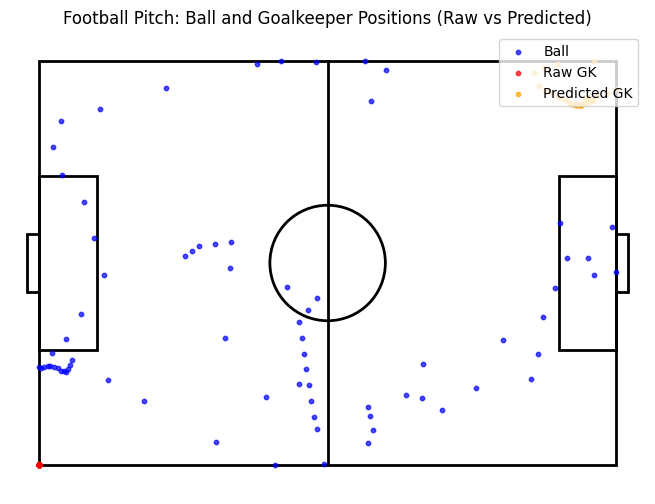

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to draw a football pitch
def draw_pitch(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Pitch Outline
    pitch = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(pitch)
    
    # Center Circle
    center_circle = patches.Circle([0.5, 0.35], 0.1, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(center_circle)
    
    # Halfway Line
    ax.plot([0.5, 0.5], [0, 0.7], color="black", lw=2)
    
    # Penalty Areas
    penalty_area_left = patches.Rectangle([0, 0.2], 0.1, 0.3, edgecolor="black", facecolor="none", lw=2)
    penalty_area_right = patches.Rectangle([0.9, 0.2], 0.1, 0.3, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(penalty_area_left)
    ax.add_patch(penalty_area_right)
    
    # Goals
    goal_left = patches.Rectangle([-0.02, 0.3], 0.02, 0.1, edgecolor="black", facecolor="none", lw=2)
    goal_right = patches.Rectangle([1, 0.3], 0.02, 0.1, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(goal_left)
    ax.add_patch(goal_right)
    
    # Set limits and aspect
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 0.75)
    ax.set_aspect("equal")
    ax.axis("off")
    return ax

# Normalize positions to fit within the pitch dimensions
df["pitch_ball_x"] = (df["ball_x"] - df["ball_x"].min()) / (df["ball_x"].max() - df["ball_x"].min())
df["pitch_ball_y"] = (df["ball_y"] - df["ball_y"].min()) / (df["ball_y"].max() - df["ball_y"].min()) * 0.7
df["pitch_gk_x"] = (df["gk_x"] - df["gk_x"].min()) / (df["gk_x"].max() - df["gk_x"].min())
df["pitch_gk_y"] = (df["gk_y"] - df["gk_y"].min()) / (df["gk_y"].max() - df["gk_y"].min()) * 0.7

# Separate raw and predicted GK positions
raw_gk = df[~df["gk_missing"]]  # Rows where GK positions are not missing
predicted_gk = df[df["gk_missing"]]  # Rows where GK positions were predicted

# Plot the football pitch and positions
ax = draw_pitch()
ax.scatter(df["pitch_ball_x"], df["pitch_ball_y"], color="blue", label="Ball", alpha=0.7, s=10)
ax.scatter(raw_gk["pitch_gk_x"], raw_gk["pitch_gk_y"], color="red", label="Raw GK", alpha=0.7, s=10)
ax.scatter(predicted_gk["pitch_gk_x"], predicted_gk["pitch_gk_y"], color="orange", label="Predicted GK", alpha=0.7, s=10)

# Add legend and title
ax.legend(loc="upper right")
ax.set_title("Football Pitch: Ball and Goalkeeper Positions (Raw vs Predicted)")

plt.show()